# ML-based-WAF Classifier (Colab)

This notebook trains a WAF model with the [WAF-A-MoLE Dataset](https://github.com/zangobot/wafamole_dataset/), based off vladan stojnic's open source [ML-based-WAF](https://github.com/vladan-stojnic/ML-based-WAF) implementation.

Tested classifier types: 
* Non-Linear SVM classifier;
* Stochastic Gradient Descent;
* AdaBoost classifier

WARNING: Only works with conda env set to mlWaf2 (provided in /deps/conda_envs).

#### Library imports and installs

In [ ]:
!pip install scikit-learn==0.21.1
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 13.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.5 MB 207 kB/s 
     |████████████████████████████████| 8.8 MB 47.0 MB/s 
     |████████████████████████████████| 144 kB 53.2 MB/s 
     |███

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from ray.util.joblib import register_ray
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

Mounted at /content/drive


In [ ]:
data_df = pd.read_json('drive/My Drive/@tcc/wafamole_dataset.json' , orient='records')
data_df

,pattern,type
0,SELECT `col2` FROM `tab` WHERE `col1` LIKE '%'...,sqli
1,"DELETE FROM `tab` WHERE `col2` < ""exec sp_addl...",sqli
2,"INSERT INTO `tab` ( `col2`, `col2` ) VALUES ( ...",sqli
3,"INSERT INTO `tab` ( `col1` ) VALUES ( '"" OR EL...",sqli
4,"INSERT INTO `tab` ( `col2` ) VALUES ( ""';\n if...",sqli
...,...,...
738823,"DELETE FROM `tab` WHERE `col1` LIKE ""%'g'%"" OR...",valid
738824,"SELECT `col3`, `col3` FROM `tab` WHERE `col3` ...",valid
738825,UPDATE `tab` SET `col3` = 2 WHERE `col1` = 334...,valid
738826,"SELECT `col2`, `col1`, `col2`, `col1` FROM `ta...",valid


sqli     393629
valid    345199
Name: type, dtype: int64


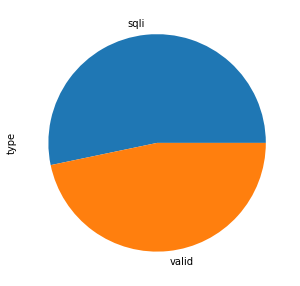

In [ ]:
counts = data_df['type'].value_counts()
print(counts)
counts.plot.pie(figsize=(5, 5))

#### Split into training and testing labels


In [ ]:
X = pd.arrays.StringArray(data_df['pattern'].to_numpy()).to_numpy()
y = pd.arrays.StringArray(data_df['type'].to_numpy()).to_numpy()

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

#### Prepare for GridSearchCV classification for best params based on Classifier type
Note - Linear with ngram range [1,4] seems to perform slightly worse than rbf kernel with ngram_range [1,2].

In [ ]:
# pipe = make_pipeline(
#     TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024), 
#     SVC())
# param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4)], 
#               'svc__C': [1, 10], 'svc__kernel': ['linear', 'rbf']}  
# grid = GridSearchCV(pipe, param_grid, cv = 2, verbose = 4, n_jobs=4)
# grid.fit(trainX, trainY)
# grid.best_params_

#### 1. Train SVC model with best params and .dump export
Found by experimenting with top results from GridSearchCV run

In [ ]:
# pipe = make_pipeline(
#     TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 2)), 
#     SVC(C = 10, kernel = 'rbf', probability=True, gamma='scale'))

# register_ray()
# with joblib.parallel_backend('ray'):
#   pipe.fit(trainX, trainY)
#   pipe.score(testX, testY)
#   joblib.dump(pipe, 'drive/My Drive/@tcc/test_svc_classifier.dump')


#### 2. Train model with suggested GridSearch optimal params
**WARNING** do not run this cell if the previous cell has been executed!

Uses best result from GridSearchCV run - however the performance is slightly worse.

In [ ]:
# pipe = make_pipeline(
#     TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 4)), 
#     SVC(C = 10, kernel = 'linear', probability=True, gamma='scale'))
# pipe.fit(trainX, trainY)
# pipe.score(testX, testY)

#### 3. Train alternate SGD model with best params and .dump export
Second used classifier

In [ ]:
# pipe = make_pipeline(
#     TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 2)), 
#     SGDClassifier(loss="modified_huber", penalty="l2", max_iter=500))

# register_ray()
# with joblib.parallel_backend('ray'):
#   pipe.fit(trainX, trainY)
#   pipe.score(testX, testY)
#   joblib.dump(pipe, 'drive/My Drive/@tcc/test_sgd_classifier.dump')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [ ]:
pipe = make_pipeline(
    TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 2)), 
    AdaBoostClassifier(n_estimators=100, random_state=0))
register_ray()
with joblib.parallel_backend('ray'):
  pipe.fit(trainX, trainY)
  pipe.score(testX, testY)
  joblib.dump(pipe, 'drive/My Drive/@tcc/test_qda_classifier.dump')


/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

#### Conclusion: Classification Reports, Confusion Matrix and .dump export
For evaluating the trained models


In [ ]:
pipe = joblib.load('drive/My Drive/@tcc/test_sgd_classifier.dump')
pipe.score(testX, testY)
predY = pipe.predict(testX)
print(classification_report(testY, predY))
print(confusion_matrix(testY, predY))
print(pipe.score(testX, testY))

pipe = joblib.load('drive/My Drive/@tcc/test_ada_classifier.dump')
pipe.score(testX, testY)
predY = pipe.predict(testX)
print(classification_report(testY, predY))
print(confusion_matrix(testY, predY))
print(pipe.score(testX, testY))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

              precision    recall  f1-score   support

        sqli       0.95      1.00      0.98     98407
       valid       1.00      0.94      0.97     86300

    accuracy                           0.97    184707
   macro avg       0.98      0.97      0.97    184707
weighted avg       0.97      0.97      0.97    184707

[[98388    19]
 [ 4888 81412]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


0.9734336002425463
              precision    recall  f1-score   support

        sqli       0.96      0.99      0.98     98407
       valid       0.99      0.96      0.97     86300

    accuracy                           0.98    184707
   macro avg       0.98      0.97      0.98    184707
weighted avg       0.98      0.98      0.98    184707

[[97746   661]
 [ 3830 82470]]
0.9756858159138527


#### WAF-A-MoLE query testing
For testing with and without WAF queries in dataset.

In [ ]:
clf = joblib.load('test_svc_classifier_extra_moled.dump')
# query = "admin'   OR   5o8x4x4o0o1=0o4o2b4b4o0b60#"
query = "aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo;"
print("Testing query {} for SQL Injection".format(query))
print("type assumed: {}".format(clf.predict([query])))
print("probability of being SQL injection is: {}".format(clf.predict_proba([query])[0,0]))

Testing query aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo; for SQL Injection
type assumed: ['sqli']
probability of being SQL injection is: 0.7964570358168855


In [ ]:
clf = joblib.load('test_svc_classifier_moled.dump')
# query = "admin'   OR   5o8x4x4o0o1=0o4o2b4b4o0b60#"
query = "aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo;"
print("Testing query {} for SQL Injection".format(query))
print("type assumed: {}".format(clf.predict([query])))
print("probability of being SQL injection is: {}".format(clf.predict_proba([query])[0,0]))

Testing query aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo; for SQL Injection
type assumed: ['valid']
probability of being SQL injection is: 0.4547222533415284


In [ ]:
clf = joblib.load('drive/My Drive/@tcc/test_sgd_classifier.dump')
#query = "admin'   OR   5o8x4x4o0o1=0o4o2b4b4o0b60#"
#query = "aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo;"
print("Testing query {} for SQL Injection".format(query))
print("type assumed: {}".format(clf.predict([query])))
print("probability of being SQL injection is: {}".format(clf.predict_proba([query])[0,0]))

Testing query admin! or SELECT 289289 idnioe spna 1=1-- for SQL Injection
type assumed: ['sqli']
probability of being SQL injection is: 0.7366378454135827


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
